In [23]:
# Import needed modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
%matplotlib inline


# Import the files
weather_df = pd.read_csv("Resources/Canton_Ohio_Weather.csv")
cfs_df = pd.read_excel("Resources/cfs_data_Canton.xlsx")

In [24]:
# Convert dt_iso into datetime format and convert to America/New_York timezone
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')
weather_df['dt_iso'] = weather_df['dt_iso'].dt.tz_convert("America/New_York")
weather_df['dt_iso'].head(3)

0   2014-12-31 19:00:00-05:00
1   2014-12-31 20:00:00-05:00
2   2014-12-31 21:00:00-05:00
Name: dt_iso, dtype: datetime64[ns, America/New_York]

In [25]:
# Create column to merge weather and cfs data on.  Since weather data has
# by the hour with minutes and seconds 00:00, that will need to be the same
# for CFS data.
weather_df['relation'] = weather_df['dt_iso'].dt.strftime("%Y-%m-%d %H:%M:%S")
weather_df['relation'].head(3)

0    2014-12-31 19:00:00
1    2014-12-31 20:00:00
2    2014-12-31 21:00:00
Name: relation, dtype: object

In [26]:
# Create column within CFS to merge weather with.  This returns 00:00 for 
# minutes and seconds to match weather format.
cfs_df['relation'] = cfs_df['CreateDatetime'].dt.strftime("%Y-%m-%d %H:00:00")

In [27]:
# Merge the dataframes together on relation table with weather on the out
merged_df = pd.merge(cfs_df, weather_df, on="relation", how="outer")
merged_df.head(3)

,CallID,Department,CallType,CreateDatetime,GeoFlag,AgencyType,relation,dt,dt_iso,timezone,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,6140391.0,Canton Police Department,Disturbance,2023-12-22 21:09:34.750,False,1.0,2023-12-22 21:00:00,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6140386.0,Canton Police Department,911 Hangup,2023-12-22 21:04:17.120,False,1.0,2023-12-22 21:00:00,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6140368.0,Canton Police Department,911 Hangup,2023-12-22 20:44:22.477,False,1.0,2023-12-22 20:00:00,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Create crime_data_df to only use needed columns
crime_data_df = merged_df[['CallID','CallType','CreateDatetime','relation','temp','dew_point','feels_like','temp_min','temp_max','pressure','humidity','wind_speed','weather_main','weather_description']]
crime_data_df.columns

Index(['CallID', 'CallType', 'CreateDatetime', 'relation', 'temp', 'dew_point',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'weather_main', 'weather_description'],
      dtype='object')

In [29]:
# Dropna if CallID is NA.  We will need to fill or drop weather data due to
# the time of collection being before 2024
crime_data_df = crime_data_df.dropna(subset=['CallID'], axis='rows')
crime_data_df.head()

,CallID,CallType,CreateDatetime,relation,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,weather_main,weather_description
0,6140391.0,Disturbance,2023-12-22 21:09:34.750,2023-12-22 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6140386.0,911 Hangup,2023-12-22 21:04:17.120,2023-12-22 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6140368.0,911 Hangup,2023-12-22 20:44:22.477,2023-12-22 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6140364.0,911 Hangup,2023-12-22 20:41:46.953,2023-12-22 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6140355.0,Theft,2023-12-22 20:27:56.443,2023-12-22 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Create additional fields for year, month, day etc.
crime_data_df['year'] = crime_data_df['CreateDatetime'].dt.year
crime_data_df['month'] = crime_data_df['CreateDatetime'].dt.month
crime_data_df['weekday'] = crime_data_df['CreateDatetime'].dt.weekday
crime_data_df['month_name'] = crime_data_df['CreateDatetime'].dt.month_name(locale = 'English')
crime_data_df['hour'] = crime_data_df['CreateDatetime'].dt.hour

In [31]:
# Drop NA from weather temps until we get it filled.
crime_data_df = crime_data_df.dropna(subset=["temp"],axis="rows")
crime_data_df.head()


,CallID,CallType,CreateDatetime,relation,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,weather_main,weather_description,year,month,weekday,month_name,hour
464,6137619.0,Suspicious Person,2023-12-19 18:32:55.377,2023-12-19 18:00:00,27.01,20.08,21.63,23.94,29.5,1029.0,72.0,4.61,Clouds,scattered clouds,2023,12,1,December,18
465,6137614.0,Security Check,2023-12-19 18:27:08.113,2023-12-19 18:00:00,27.01,20.08,21.63,23.94,29.5,1029.0,72.0,4.61,Clouds,scattered clouds,2023,12,1,December,18
466,6137610.0,Parking Complaint,2023-12-19 18:24:17.883,2023-12-19 18:00:00,27.01,20.08,21.63,23.94,29.5,1029.0,72.0,4.61,Clouds,scattered clouds,2023,12,1,December,18
467,6137604.0,Suspicious Person,2023-12-19 18:20:50.703,2023-12-19 18:00:00,27.01,20.08,21.63,23.94,29.5,1029.0,72.0,4.61,Clouds,scattered clouds,2023,12,1,December,18
468,6137594.0,Suspicious Person,2023-12-19 18:06:37.350,2023-12-19 18:00:00,27.01,20.08,21.63,23.94,29.5,1029.0,72.0,4.61,Clouds,scattered clouds,2023,12,1,December,18


In [32]:
# check how Domesitc Violence spikes in the summer as temperature rises
domestic_df = crime_data_df.loc[crime_data_df['CallType'].str.contains("Domestic")]
domestic_df.head()

,CallID,CallType,CreateDatetime,relation,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,weather_main,weather_description,year,month,weekday,month_name,hour
479,6137539.0,Domestic,2023-12-19 16:55:59.183,2023-12-19 16:00:00,28.81,20.64,20.93,27.16,31.32,1027.0,68.0,8.05,Clouds,broken clouds,2023,12,1,December,16
491,6137458.0,Domestic,2023-12-19 15:18:18.490,2023-12-19 15:00:00,29.25,21.06,19.56,28.09,30.94,1027.0,68.0,11.50,Clouds,overcast clouds,2023,12,1,December,15
535,6137197.0,Domestic,2023-12-19 06:31:15.410,2023-12-19 06:00:00,27.50,21.40,15.40,26.04,29.50,1020.0,75.0,16.11,Snow,light snow,2023,12,1,December,6
593,6137028.0,Domestic,2023-12-19 01:26:01.417,2023-12-19 01:00:00,27.88,20.93,16.32,27.09,29.50,1013.0,72.0,14.97,Snow,light snow,2023,12,1,December,1
594,6137028.0,Domestic,2023-12-19 01:26:01.417,2023-12-19 01:00:00,27.88,20.93,16.32,27.09,29.50,1013.0,72.0,14.97,Mist,mist,2023,12,1,December,1


In [33]:
#Predict daily count of violent crimes that occurred inside by mean maximum temperature
domestic_df.groupby('temp_max').agg({'CallType':'count'})


,CallType
temp_max,
-2.78,1
-2.27,1
-1.03,3
-0.47,5
-0.02,1
...,...
96.93,2
99.93,1
100.92,1


<Axes: xlabel='temp_max'>

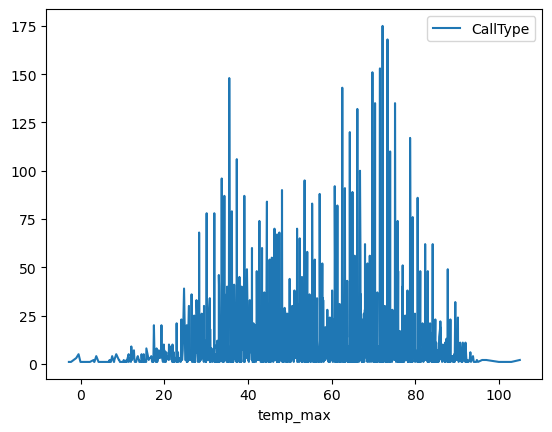

In [34]:
domestic_df.groupby('temp_max').agg({'CallType':'count'}).plot()

C:\Users\James\AppData\Local\Temp\ipykernel_12116\2429650495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domestic_df['Temperature Bin'] = domestic_df['temp_max'].apply(lambda x: round(x / 5) * 5)
C:\Users\James\AppData\Local\Temp\ipykernel_12116\2429650495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  domestic_df['month'] = domestic_df['CreateDatetime'].dt.month


<Axes: xlabel='month'>

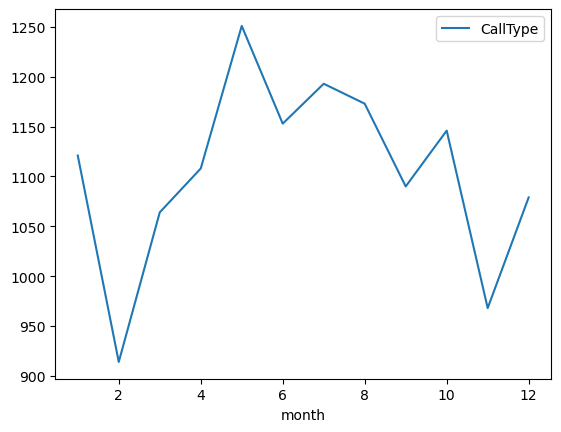

In [35]:
domestic_df['Temperature Bin'] = domestic_df['temp_max'].apply(lambda x: round(x / 5) * 5)
domestic_df['month'] = domestic_df['CreateDatetime'].dt.month
domestic_df.groupby("month").agg({"CallType":"count"}).plot()

In [36]:
domestic_df = domestic_df.reset_index(drop=True)
domestic_df.head()

,CallID,CallType,CreateDatetime,relation,temp,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,weather_main,weather_description,year,month,weekday,month_name,hour,Temperature Bin
0,6137539.0,Domestic,2023-12-19 16:55:59.183,2023-12-19 16:00:00,28.81,20.64,20.93,27.16,31.32,1027.0,68.0,8.05,Clouds,broken clouds,2023,12,1,December,16,30
1,6137458.0,Domestic,2023-12-19 15:18:18.490,2023-12-19 15:00:00,29.25,21.06,19.56,28.09,30.94,1027.0,68.0,11.50,Clouds,overcast clouds,2023,12,1,December,15,30
2,6137197.0,Domestic,2023-12-19 06:31:15.410,2023-12-19 06:00:00,27.50,21.40,15.40,26.04,29.50,1020.0,75.0,16.11,Snow,light snow,2023,12,1,December,6,30
3,6137028.0,Domestic,2023-12-19 01:26:01.417,2023-12-19 01:00:00,27.88,20.93,16.32,27.09,29.50,1013.0,72.0,14.97,Snow,light snow,2023,12,1,December,1,30
4,6137028.0,Domestic,2023-12-19 01:26:01.417,2023-12-19 01:00:00,27.88,20.93,16.32,27.09,29.50,1013.0,72.0,14.97,Mist,mist,2023,12,1,December,1,30


In [37]:
domestic_df['Date'] = domestic_df["CreateDatetime"].dt.strftime("%m/%d/%Y")
prophet_df = domestic_df.groupby(domestic_df['Date']).agg({"CallType":"count"}).reset_index()
prophet_df['Date'] = pd.to_datetime(prophet_df['Date'])
prophet_df = prophet_df.sort_values("Date")
prophet_df = prophet_df.reset_index(drop=True)
prophet_df.columns = ['ds', 'y']
prophet_df = prophet_df.dropna()
prophet_df.tail() 

,ds,y
1806,2023-12-15,7
1807,2023-12-16,3
1808,2023-12-17,5
1809,2023-12-18,7
1810,2023-12-19,7


In [38]:
m = Prophet()
m.fit(prophet_df)
# Make future timeframe 30 days out
future = m.make_future_dataframe(periods=365, freq='D')
forecast = m.predict(future)

11:38:34 - cmdstanpy - INFO - Chain [1] start processing
11:38:34 - cmdstanpy - INFO - Chain [1] done processing


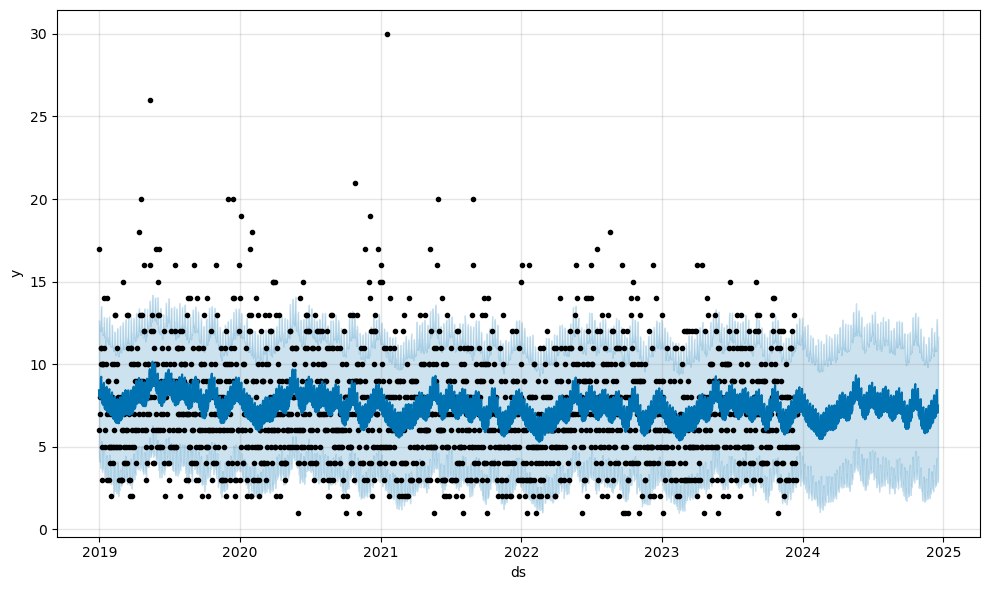

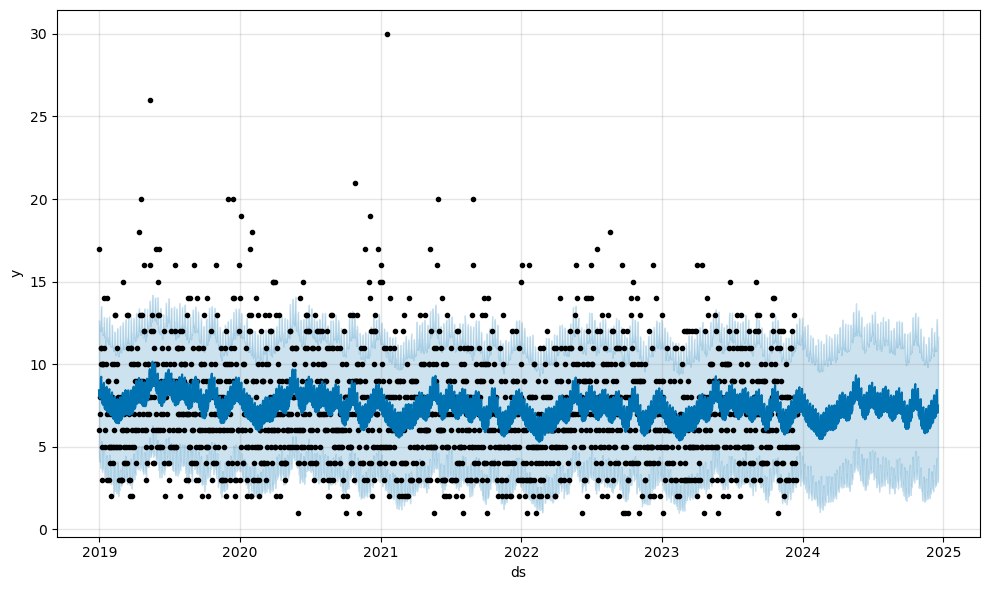

In [39]:
m.plot(forecast)

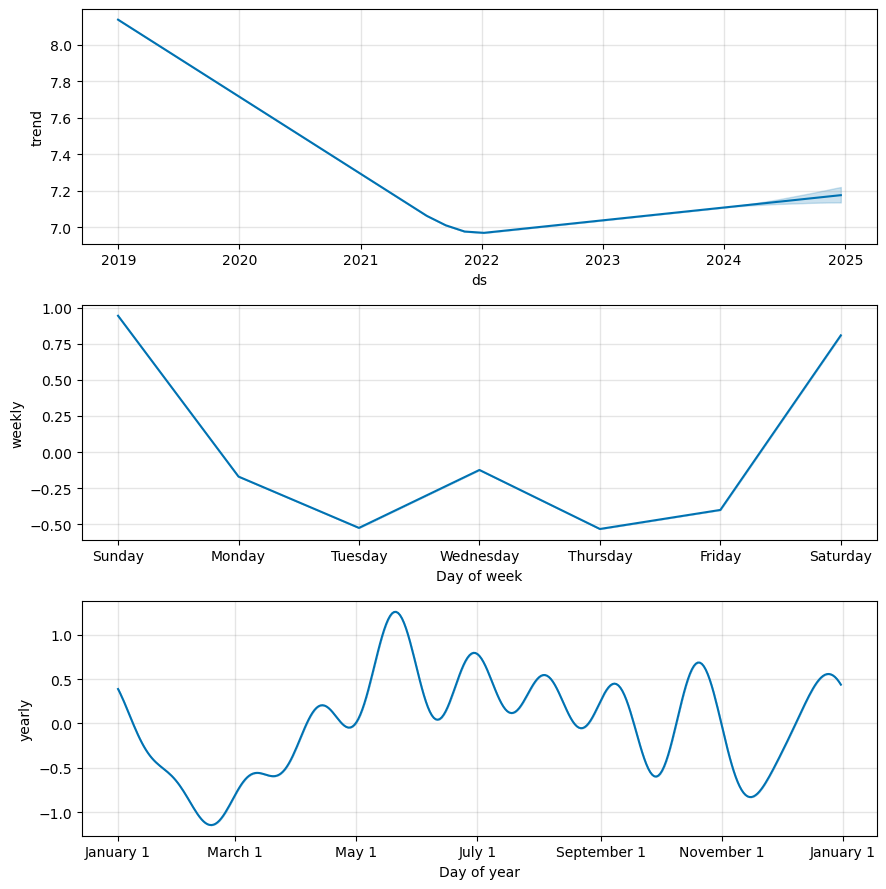

In [40]:
forecast = forecast.reset_index(drop=True)
fig2 = m.plot_components(forecast)

<Axes: xlabel='year'>

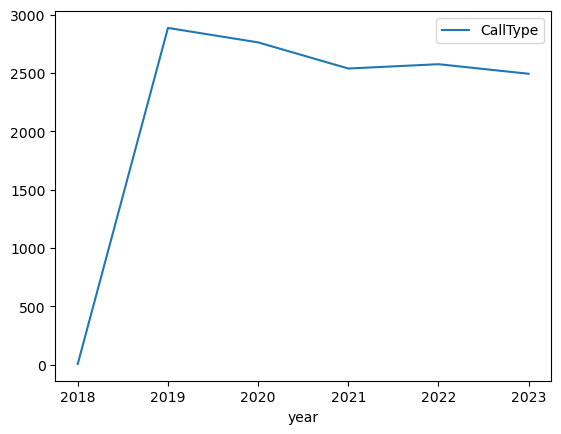

In [41]:
#domestic abuse by year
domestic_df['year'] = domestic_df['CreateDatetime'].dt.year
domestic_df.groupby("year").agg({"CallType":"count"}).plot()